Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


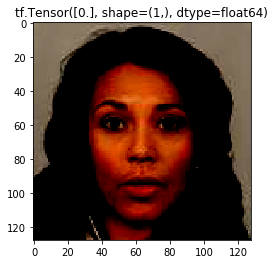

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Load Test Data
train_x = np.load('train_x.npy')
train_y = np.load('train_y.npy')
validation_x = np.load('validation_x.npy')
validation_y = np.load('validation_y.npy')

train = tf.data.Dataset.from_tensor_slices((train_x, train_y))
validation = tf.data.Dataset.from_tensor_slices((validation_x, validation_y))

# Create Batches
train_batches = train.shuffle(1000).batch(32)
validation_batches = validation.batch(32)

# View Image
for image_batch, label_batch in train_batches.take(1):
    plt.title(str(label_batch[0, :]))
    plt.imshow(image_batch[0, :, :, :])
    plt.show()

In [35]:
LEARNING_RATE = 0.0001
EPOCHS = 5
FINE_TUNE_EPOCHS = 5

# Set up Early Stopping
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              patience=3,
                                              restore_best_weights=True)

pretrained_model = tf.keras.applications.MobileNetV2(input_shape=(128, 128, 3),
                                                     include_top=False,
                                                     weights='imagenet')
pretrained_model.trainable = False

model = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1,
                          activation='sigmoid',
                          kernel_regularizer=tf.keras.regularizers.l2(0.001))
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_128 (Model) (None, 4, 4, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_14  (None, 1280)              0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 1280)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [36]:
history_transfer = model.fit(train_batches,
                             epochs=EPOCHS,
                             validation_data=validation_batches,
                             callbacks=[early_stop])

Epoch 1/5
500/500 [==============================] - 435s 871ms/step - loss: 0.4482 - accuracy: 0.7914 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/5
500/500 [==============================] - 443s 886ms/step - loss: 0.2286 - accuracy: 0.9270 - val_loss: 1.6131 - val_accuracy: 0.4958
Epoch 3/5
500/500 [==============================] - 448s 897ms/step - loss: 0.1703 - accuracy: 0.9449 - val_loss: 1.8021 - val_accuracy: 0.4960
Epoch 4/5
500/500 [==============================] - 451s 902ms/step - loss: 0.1443 - accuracy: 0.9538 - val_loss: 1.8541 - val_accuracy: 0.4963


In [37]:
pretrained_model.trainable = True
# Max is 155
fine_tune_from = 150

for layer in pretrained_model.layers[:fine_tune_from]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE/10),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_128 (Model) (None, 4, 4, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_14  (None, 1280)              0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 1280)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 721,281
Non-trainable params: 1,537,984
_________________________________________________________________


In [38]:
history_fine = model.fit(train_batches,
                         epochs=history_transfer.epoch[-1] + FINE_TUNE_EPOCHS,
                         initial_epoch = history_transfer.epoch[-1] + 1,
                         validation_data = validation_batches,
                         callbacks=[early_stop])

Epoch 5/8
500/500 [==============================] - 527s 1s/step - loss: 0.0608 - accuracy: 0.9794 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 6/8
500/500 [==============================] - 499s 998ms/step - loss: 0.0293 - accuracy: 0.9906 - val_loss: 1.6064 - val_accuracy: 0.6507
Epoch 7/8
500/500 [==============================] - 519s 1s/step - loss: 0.0225 - accuracy: 0.9934 - val_loss: 1.0046 - val_accuracy: 0.7548
Epoch 8/8
500/500 [==============================] - 554s 1s/step - loss: 0.0202 - accuracy: 0.9941 - val_loss: 0.9680 - val_accuracy: 0.7533


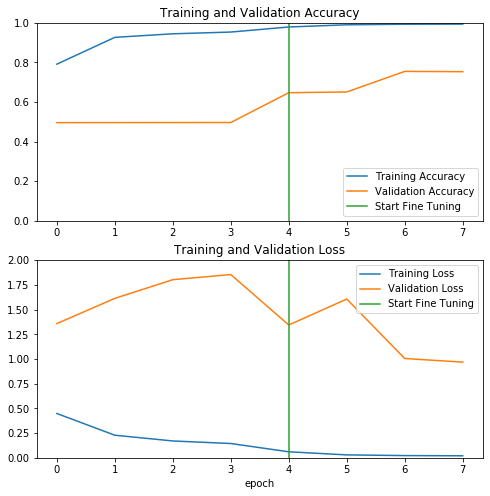

In [39]:
acc = history_transfer.history['accuracy'] + history_fine.history['accuracy']
val_acc = history_transfer.history['val_accuracy'] + history_fine.history['val_accuracy']

loss = history_transfer.history['loss'] + history_fine.history['loss']
val_loss = history_transfer.history['val_loss'] +  history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([EPOCHS-1,EPOCHS-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 2.0])
plt.plot([EPOCHS-1,EPOCHS-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [40]:
model.save('new_model.h5')